In [57]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ProjetOpenClassrooms/OnboadSystem_Model/
import os
CITYSCAPES_ROOT = "./data"

MODEL_PATH = "/content/drive/MyDrive/ProjetOpenClassrooms/OnboadSystem_Model/keras_virgin_trainingless.keras"
IMG_HEIGHT, IMG_WIDTH = 256, 512
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
NUM_CLASSES = 8
BATCH_SIZE = 16
EPOCHS = 25
LR = 1e-4

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ProjetOpenClassrooms/OnboadSystem_Model


In [58]:
# Images et masques, par split
LEFTIMG_DIR = os.path.join(CITYSCAPES_ROOT, "leftImg8bit")
MASK_DIR    = os.path.join(CITYSCAPES_ROOT, "gtFine")

# Chemins complets
TRAIN_IMG_DIR = os.path.join(LEFTIMG_DIR, "train")
VAL_IMG_DIR   = os.path.join(LEFTIMG_DIR, "val")
TEST_IMG_DIR  = os.path.join(LEFTIMG_DIR, "test")

TRAIN_MASK_DIR = os.path.join(MASK_DIR, "train")
VAL_MASK_DIR   = os.path.join(MASK_DIR, "val")
TEST_MASK_DIR  = os.path.join(MASK_DIR, "test")

In [59]:
from PIL import Image
base_path = "./data"


In [60]:
# Mapping de l’ID des classes vers les 8 catégories principales
CITYSCAPES_8_CLASSES = {
        # flat
        7: 0, 8: 0, 9: 7, 10: 7,  # road, sidewalk, parking, rail track

        # human
        24: 1, 25: 1,  # person, rider

        # vehicle
        26: 2, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 2, 33: 2,  # car, truck, bus, train, motorcycle, etc.

        # construction
        11: 3, 12: 3, 13: 3, 14: 3, 15: 3, 16: 3, 17: 4,  # building, wall, fence, etc.

        # object
        18: 4, 19: 4, 20: 4,  # pole, traffic light/sign

        # nature
        21: 5, 22: 5,  # vegetation, terrain

        # sky
        23: 6,  # sky

        # void (tout le reste → 7)
}

def remap_mask(mask):
    """Transforme les classes Cityscapes en 8 classes cibles (valeurs 0 à 7)"""
    mask_array = np.array(mask)
    new_mask = np.zeros_like(mask_array)

    for k, v in CITYSCAPES_8_CLASSES.items():
        new_mask[mask_array == k] = v

    return new_mask.astype(np.int64)  # ✅ conversion explicite

In [61]:
import os
import glob

def get_cityscapes_pairs(img_root, mask_root, split="train"):
    image_paths, mask_paths = [], []

    for city in os.listdir(img_root):
        img_dir = os.path.join(img_root, city)
        mask_dir = os.path.join(mask_root, city)

        img_files = glob.glob(os.path.join(img_dir, "*_leftImg8bit.png"))

        for img_path in img_files:
            filename = os.path.basename(img_path).replace("_leftImg8bit.png", "")
            mask_path = os.path.join(mask_dir, f"{filename}_gtFine_labelIds.png")

            if os.path.exists(mask_path):
                image_paths.append(img_path)
                mask_paths.append(mask_path)
            else:
                print(f"⚠️ Masque manquant pour : {mask_path}")

    print(f"✅ {split} : {len(image_paths)} paires valides trouvées")
    return image_paths, mask_paths


In [62]:
train_img, train_mask = get_cityscapes_pairs(TRAIN_IMG_DIR, TRAIN_MASK_DIR, "train")
val_img, val_mask     = get_cityscapes_pairs(VAL_IMG_DIR, VAL_MASK_DIR, "val")
test_img, test_mask   = get_cityscapes_pairs(TEST_IMG_DIR, TEST_MASK_DIR, "test")


✅ train : 2975 paires valides trouvées
✅ val : 500 paires valides trouvées
✅ test : 1525 paires valides trouvées


In [63]:
train_img, train_mask = get_cityscapes_pairs(TRAIN_IMG_DIR, TRAIN_MASK_DIR, "train")
val_img, val_mask     = get_cityscapes_pairs(VAL_IMG_DIR, VAL_MASK_DIR, "val")
test_img, test_mask   = get_cityscapes_pairs(TEST_IMG_DIR, TEST_MASK_DIR, "test")

# Réduire le dataset d'entraînement à 100 images
#train_img = train_img[:100]
#train_mask = train_mask[:100]


✅ train : 2975 paires valides trouvées
✅ val : 500 paires valides trouvées
✅ test : 1525 paires valides trouvées


In [64]:
import glob

def get_image_paths(root_dir):
    image_paths = []
    for city_folder in os.listdir(root_dir):
        folder_path = os.path.join(root_dir, city_folder)
        image_paths.extend(glob.glob(os.path.join(folder_path, "*_leftImg8bit.png")))
    return sorted(image_paths)


In [65]:
IMG_DIR = os.path.join(CITYSCAPES_ROOT, "leftImg8bit")
GT_DIR = os.path.join(CITYSCAPES_ROOT, "gtFine")

train_imgs = get_image_paths(os.path.join(IMG_DIR, "train"))
val_imgs = get_image_paths(os.path.join(IMG_DIR, "val"))
test_imgs = get_image_paths(os.path.join(IMG_DIR, "test"))


In [66]:
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.utils import Sequence

class CityscapesSequence(Sequence):
    def __init__(self, image_paths, mask_paths, batch_size, img_size, num_classes, shuffle=True, augment=False):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.img_size = img_size  # (width, height)
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()

    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def on_epoch_end(self):
        if self.shuffle:
            temp = list(zip(self.image_paths, self.mask_paths))
            np.random.shuffle(temp)
            self.image_paths, self.mask_paths = zip(*temp)

    def __getitem__(self, idx):
        batch_img_paths = self.image_paths[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_mask_paths = self.mask_paths[idx * self.batch_size : (idx + 1) * self.batch_size]

        X = np.zeros((self.batch_size, self.img_size[1], self.img_size[0], 3), dtype=np.float32)
        Y = np.zeros((self.batch_size, self.img_size[1], self.img_size[0]), dtype=np.uint8)

        for i, (img_path, mask_path) in enumerate(zip(batch_img_paths, batch_mask_paths)):
            # Image
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.img_size)
            img = img / 255.0
            img = (img - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]

            # Masque
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is None:
                raise FileNotFoundError(f"Masque introuvable ou vide : {mask_path}")
            mask = cv2.resize(mask, self.img_size, interpolation=cv2.INTER_NEAREST)
            mask = remap_mask(mask)

            # Flip (si augmentation active)
            if self.augment and np.random.rand() < 0.5:
                img = cv2.flip(img, 1)
                mask = cv2.flip(mask, 1)

            X[i] = img
            Y[i] = mask

        return X, tf.keras.utils.to_categorical(Y, self.num_classes)


In [67]:
train_dataset = CityscapesSequence(train_img, train_mask, BATCH_SIZE, IMG_SIZE, NUM_CLASSES, shuffle=True, augment=True)
val_dataset   = CityscapesSequence(val_img, val_mask, BATCH_SIZE, IMG_SIZE, NUM_CLASSES, shuffle=False, augment=False)



In [68]:
print("Nombre d'exemples dans train_dataset :", len(val_dataset))


Nombre d'exemples dans train_dataset : 31


In [69]:
def resize_like(inputs):
        x, ref = inputs
        return tf.image.resize(x, size=tf.shape(ref)[1:3], method='bilinear')


In [70]:
#model = tf.keras.models.load_model(MODEL_PATH, custom_objects={'resize_like': resize_like})


In [71]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model

In [78]:
def unet_resnet50(input_shape=(256, 512, 3), num_classes=8):
    inputs = Input(shape=input_shape)
    base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)

    # Skip connections
    skip1 = base_model.get_layer("conv1_relu").output         # 64x128
    skip2 = base_model.get_layer("conv2_block3_out").output   # 32x64
    skip3 = base_model.get_layer("conv3_block4_out").output   # 16x32
    skip4 = base_model.get_layer("conv4_block6_out").output   # 8x16
    bridge = base_model.get_layer("conv5_block3_out").output  # 4x8

    # Decoder
    x = Conv2DTranspose(512, 3, strides=2, padding='same')(bridge)   # 4x8 → 8x16
    x = Concatenate()([x, skip4])
    x = Conv2D(512, 3, activation='relu', padding='same')(x)

    x = Conv2DTranspose(256, 3, strides=2, padding='same')(x)        # 8x16 → 16x32
    x = Concatenate()([x, skip3])
    x = Conv2D(256, 3, activation='relu', padding='same')(x)

    x = Conv2DTranspose(128, 3, strides=2, padding='same')(x)        # 16x32 → 32x64
    x = Concatenate()([x, skip2])
    x = Conv2D(128, 3, activation='relu', padding='same')(x)

    x = Conv2DTranspose(64, 3, strides=2, padding='same')(x)         # 32x64 → 64x128
    x = Concatenate()([x, skip1])
    x = Conv2D(64, 3, activation='relu', padding='same')(x)

    x = Conv2DTranspose(32, 3, strides=2, padding='same')(x)         # 64x128 → 128x256
    x = Conv2D(32, 3, activation='relu', padding='same')(x)

    x = Conv2D(16, 3, activation='relu', padding='same')(x)          # pas de upsample final
    outputs = Conv2D(num_classes, 1, activation='softmax')(x)        # 128x256 → softmax → 256x512xC

    return Model(inputs, outputs)


In [79]:
model = unet_resnet50(input_shape=(256, 512, 3), num_classes=8)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 256, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 518,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 256,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 256,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 256,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 258,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 128,   │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 128,   │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 128,   │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 128,   │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 128,   │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 128,   │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 128,   │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 128,   │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 128,   │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 128,   │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 128,   │      1,024 │ conv2_block1_3_c

 Total params: 43,971,032 (167.74 MB)

 Trainable params: 43,917,912 (167.53 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [80]:
!pip install mlflow

In [81]:
import numpy as np
import mlflow
from sklearn.metrics import f1_score
from tensorflow.keras.metrics import MeanIoU


def log_extended_metrics(y_true, y_pred, epoch):
    # Conversion en 1D pour sklearn
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    # F1 score macro
    f1 = f1_score(y_true_flat, y_pred_flat, average='macro')

    # mIoU global via Keras
    mean_iou_metric = MeanIoU(num_classes=NUM_CLASSES)
    mean_iou_metric.update_state(y_true, y_pred)
    miou = mean_iou_metric.result().numpy()

    # IoU par classe (si besoin pour détailler)
    conf_matrix = mean_iou_metric.get_weights()[0]
    iou_by_class = []
    for i in range(NUM_CLASSES):
        intersection = conf_matrix[i, i]
        union = (np.sum(conf_matrix[i, :]) + np.sum(conf_matrix[:, i]) - intersection)
        if union > 0:
            iou = intersection / union
        else:
            iou = np.nan  # ou 0 si tu veux le forcer
        iou_by_class.append(iou)

    # Log principal
    mlflow.log_metrics({
        "val_mIoU": miou,
        "val_f1_score": f1
    }, step=epoch)

    # Log IoU par classe
    for i, iou in enumerate(iou_by_class):
        if not np.isnan(iou):
            mlflow.log_metric(f"val_iou_class_{i}", iou, step=epoch)

In [82]:
import numpy as np

def get_preds(model, dataset):
    y_true = []
    y_pred = []

    for images, masks in dataset:
        preds = model.predict(images)
        preds = np.argmax(preds, axis=-1)
        masks = np.argmax(masks, axis=-1) if masks.ndim == 4 else masks

        y_pred.extend(preds.reshape(-1))
        y_true.extend(masks.reshape(-1))

    return np.array(y_true), np.array(y_pred)


In [83]:


import mlflow

# Lancer MLflow manuellement
mlflow.set_experiment("UNet_segmentation_cityscapes")
with mlflow.start_run(run_name="Unet_Keras_ResNet50"):
    # Log des hyperparamètres
    mlflow.log_params({
        "model": "UNet_ResNet50_Custom",
        "optimizer": "Adam",
        "learning_rate": LR,
        "loss": "categorical_crossentropy",
        "batch_size": BATCH_SIZE,
        "img_size": IMG_SIZE,
        "epochs": EPOCHS
    })

# Sortir complètement de MLflow et ENTRAÎNER le modèle
# Recompiler si nécessaire
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Appel natif autorisé avec workers
history = tf.keras.Model.fit(
    model,
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
)

# Sauvegarde finale du modèle (optionnel si déjà logué avant)
model.save("saved_model_keras_larger.keras")

mlflow.end_run()

Epoch 1/25
185/185 ━━━━━━━━━━━━━━━━━━━━ 554s 2s/step - accuracy: 0.4623 - loss: 1.3640 - val_accuracy: 0.5909 - val_loss: 1.8550
Epoch 2/25
185/185 ━━━━━━━━━━━━━━━━━━━━ 409s 2s/step - accuracy: 0.8833 - loss: 0.4353 - val_accuracy: 0.6896 - val_loss: 1.1816
Epoch 3/25
185/185 ━━━━━━━━━━━━━━━━━━━━ 410s 2s/step - accuracy: 0.9086 - loss: 0.3004 - val_accuracy: 0.8492 - val_loss: 0.5221
Epoch 4/25
185/185 ━━━━━━━━━━━━━━━━━━━━ 421s 2s/step - accuracy: 0.9180 - loss: 0.2591 - val_accuracy: 0.8768 - val_loss: 0.4242
Epoch 5/25
185/185 ━━━━━━━━━━━━━━━━━━━━ 414s 2s/step - accuracy: 0.9257 - loss: 0.2285 - val_accuracy: 0.9117 - val_loss: 0.2844
Epoch 6/25
185/185 ━━━━━━━━━━━━━━━━━━━━ 411s 2s/step - accuracy: 0.9309 - loss: 0.2077 - val_accuracy: 0.9208 - val_loss: 0.2445
Epoch 7/25
185/185 ━━━━━━━━━━━━━━━━━━━━ 411s 2s/step - accuracy: 0.9362 - loss: 0.1869 - val_accuracy: 0.9193 - val_loss: 0.2452
Epoch 8/25
185/185 ━━━━━━━━━━━━━━━━━━━━ 412s 2s/step - accuracy: 0.9386 - loss: 0.1786 - val_accu

In [84]:
import glob
import os

def get_test_image_paths(root_dir):
    test_dir = os.path.join(root_dir, "leftImg8bit", "test")
    test_images = glob.glob(os.path.join(test_dir, "*", "*_leftImg8bit.png"))
    return sorted(test_images)

test_image_paths = get_test_image_paths("./data")


In [85]:
# Inverser la normalisation pour l’affichage
def denormalize(img):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = (img * std) + mean
    return np.clip(img, 0, 1)


In [86]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, dataset, num_batches=1, has_labels=True):
    for batch_idx in range(num_batches):
        batch = dataset[batch_idx]

        if has_labels:
            X_batch, Y_true = batch
        else:
            X_batch = batch
            Y_true = None

        Y_pred = model.predict(X_batch)
        Y_pred = np.argmax(Y_pred, axis=-1)

        if Y_true is not None:
            Y_true = np.argmax(Y_true, axis=-1)

        for i in range(len(X_batch)):
            fig, axes = plt.subplots(1, 2 if Y_true is None else 3, figsize=(15, 5))
            axes[0].imshow(denormalize(X_batch[i]))
            axes[0].set_title("Image")

            if Y_true is not None:
                axes[1].imshow(Y_true[i])
                axes[1].set_title("Masque réel")
                axes[2].imshow(Y_pred[i])
                axes[2].set_title("Prédiction")
            else:
                axes[1].imshow(Y_pred[i])
                axes[1].set_title("Prédiction")

            for ax in axes:
                ax.axis("off")
            plt.show()


In [87]:
class CityscapesTestSequence(tf.keras.utils.Sequence):
    def __init__(self, image_paths, batch_size, img_size):
        self.image_paths = image_paths
        self.batch_size = batch_size
        self.img_size = img_size

    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def __getitem__(self, idx):
        batch_paths = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        X = np.zeros((len(batch_paths), self.img_size[1], self.img_size[0], 3), dtype=np.float32)

        for i, path in enumerate(batch_paths):
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.img_size)
            img = img / 255.0
            img = (img - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]
            X[i] = img

        return X


In [88]:
test_dataset = CityscapesTestSequence(test_imgs, BATCH_SIZE, IMG_SIZE)


In [89]:
visualize_predictions(model, test_dataset, num_batches=1, has_labels=False)



Output hidden; open in https://colab.research.google.com to view.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


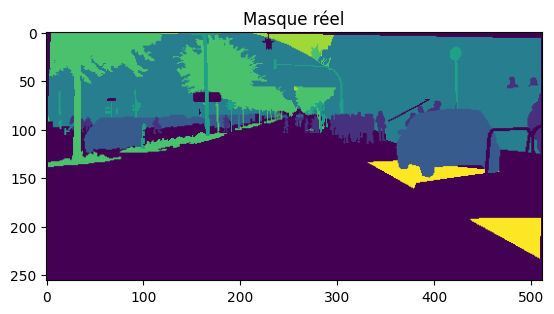

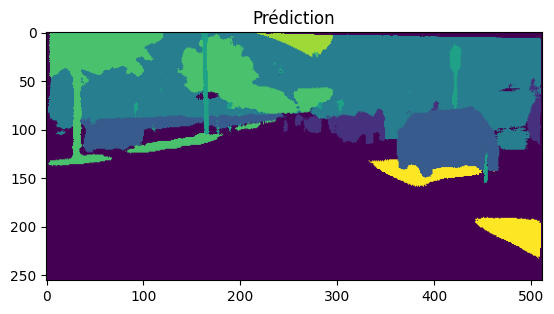

In [90]:
X, Y = train_dataset[0]
Y_pred = model.predict(X)
Y_pred_classes = np.argmax(Y_pred, axis=-1)
Y_true_classes = np.argmax(Y, axis=-1)

# Compare visuellement
plt.imshow(Y_true_classes[0])
plt.title("Masque réel")

plt.figure()
plt.imshow(Y_pred_classes[0])
plt.title("Prédiction")
plt.show()
